# Script for extracting ocean model data and writing field subsets to netCDF

In [1]:
import numpy as np
import xarray as xa
import matplotlib.pyplot as plt
import cmocean
import datetime
import cartopy.crs as ccrs
import pandas as pd
import scipy.ndimage as nd                                                                                                                                                          

In [2]:
# Specify NK800 or Barents2.5, two operational ocean circulation models at the Norwegian Meteorological Institute
model = "NK"#"Barents" #"NK"

In [3]:
#Read data
if model == "NK":
    roms_file = 'https://thredds.met.no/thredds/dodsC/sea/norkyst800m/1h/aggregate_be'
    ocn_m = xa.open_dataset(roms_file)
elif model == "Barents":
    roms_file = 'https://thredds.met.no/thredds/dodsC/barents25km_agg'
    ocn_m = xa.open_dataset(roms_file)



## File variable naming convention
Here, it important for the user to know the convention of the ocean model. For the two examples provided, the $\mathbf{U} = (U,V)$ components are denoted
- u_eastward, v_northward in NK
- u, v in Barents.

Furthermore, the recall the convention of the depth data, which in the two examples provided use $h$.

## Data subsetting
Data can be subset in terms of 
1. variables (VOI: variables of interest)
2. horizontal extent (AOI: area of interest)
3. temporal extent (TOI: times of interest)

Here we will show an example of such subsetting. First we plot the overview of the data, and an AOI based on the total extent

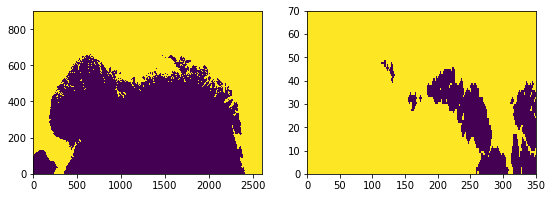

In [4]:
wetmask = ocn_m.h.data > 11.
wetmask = nd.binary_erosion(wetmask)

# Bounding boxes for AOI 
bbox_idx = slice(1350,1700,1) #latitude AOI
bbox_idy = slice(610,680,1) #longitude AOI

fig,ax = plt.subplots(ncols=2,figsize=(9,3))
ax[0].pcolormesh(wetmask)
ax[1].pcolormesh(wetmask[bbox_idy,bbox_idx])

Now, we define the subsets for VOI and TOI

In [5]:
# Variables of interest
VOI = [ 
    'u_eastward',
    'v_northward',
    'h'
]

In [13]:
TOI=pd.date_range("2019-01-04T07",'2019-01-04T21', periods=15)

We then apply the subsets of the ocn_m object utilizing the selection utility of xarray. Note that we only select the surface current layer

In [14]:
ocn_m_subset=ocn_m[VOI].sel(time=TOI,method='nearest').isel(depth=0,X=bbox_idx,Y=bbox_idy)

# Write to NetCDF
Once the subset is created, it can now be written to disk

In [15]:
ocn_m_subset.to_netcdf('ocean_model_subset.nc')